DAYMET Downscaler NB1 - Gather Data
================================
**Author:** Xavier R Nogueira

**Overview:** Uses DAYMET [single pixel extractor API](https://daymet.ornl.gov/web_services#single), in conjunction with [US Hourly precipitation gage data](https://www.ncei.noaa.gov/maps/hourly/?layers=001) to train a model using a model that is a concrete implementation of the machine learning Python protocol defined in `machine_learning/protocols.py`.

Note: The goal here is to develop a performant, but data source light, prediction model such that data access for any region is rapid, and model explainability remains high.

## Potential features
* DAYMET data - raw daily value columns:
    * `tmax` - maximum temperature.
    * `tmin` - minimum temperature.
    * `srad` - shortwave radiation.
    * `vp` - vapor pressure.
    * `swe` - snow-water equivalent.
    * `prcp` - precipitation.
    * `dayl` - daylength.
    * **Note:** DAYMET data will be resampled (method pending) such that it can match the resolution of our 30m elevation data.
* Elevation data - 3DEP DEMs from [`Py3DEP`](https://docs.hyriver.io/readme/py3dep.html) are used to make the following features.
    * `raw_z` - raw elevation above SL.
    * `rel_z` - elevation 
* Kriging prediction - use just the ground data to predict spatially

## Environment prep

In [2]:
# import base python libaries
import requests
import datetime
import gc
from typing import Tuple, Dict, Union
from pathlib import Path

# import data manipulation libraries
import numpy as np
import pandas as pd
import xarray as xr
import scipy
import geopandas as gpd
from shapely.geometry import Polygon

# import hyrivers libraries to access data
import pydaymet
import py3dep

In [3]:
# chose the output resolution for our predictions (in meters)
OUTPUT_RESOLUTION = 200

# Pull in data

## Define temporal/spatial AOI

In [6]:
# define a state to use data from
STATE = 'pennsylvania'

# define a date range to pull daily values from - i.e. (str) '2005-01-25'
start = '2016-01-01'
end = '2021-12-31'

# covnert to datetime
start_dt = datetime.datetime.strptime(start, r'%Y-%m-%d')
end_dt = datetime.datetime.strptime(end, r'%Y-%m-%d')
date_range = (start_dt, end_dt)

In [10]:
end_dt.strftime(r'%Y-%m-%d')

'2021-12-31'

In [8]:
end_dt

datetime.datetime(2021, 12, 31, 0, 0)

In [14]:
def get_state_bbox(
    state_name: str,
        ) -> Tuple[float, float, float, float]:
    """
    Get the bounding box of a US state in EPSG4326 given it's name
    :param place: (str) a valid state name in english.
    :returns: (tuple) a tuple w/ coordinates as floats i.e.,
        [[11.777, 53.7253321, -70.2695876, 7.2274985]].
    """
    # create url to pull openstreetmap data
    url_prefix = 'http://nominatim.openstreetmap.org/search?state='

    url = '{0}{1}{2}'.format(url_prefix, state_name.lower(), '&format=json&polygon=0')
    response = requests.get(url).json()[0]

    lst = response['boundingbox']
    coors = [float(i) for i in lst]
    return {
        'xmin': coors[-2],
        'xmax': coors[-1],
        'ymin': coors[0],
        'ymax': coors[1],
        }

In [15]:
%%time
bbox_dict = get_state_bbox(STATE)
display(bbox_dict)

{'xmin': -80.5210833,
 'xmax': -74.689672,
 'ymin': 39.7197662,
 'ymax': 42.5146891}

CPU times: total: 31.2 ms
Wall time: 683 ms


### Build a dictionary to map state names to FIPs codes

In [16]:
# use the census api to get state names as a list of lists
list_of_pairs = list(
    requests.get(
        r'https://api.census.gov/data/2010/dec/sf1?get=NAME&for=state:*'
    ).json()
)

state_fips_dict = {}
for pair in list_of_pairs:
    if pair[0] != 'NAME': state_fips_dict[pair[0].lower()] = str(pair[-1])
display(state_fips_dict)

{'alabama': '01',
 'alaska': '02',
 'arizona': '04',
 'arkansas': '05',
 'california': '06',
 'louisiana': '22',
 'kentucky': '21',
 'colorado': '08',
 'connecticut': '09',
 'delaware': '10',
 'district of columbia': '11',
 'florida': '12',
 'georgia': '13',
 'hawaii': '15',
 'idaho': '16',
 'illinois': '17',
 'indiana': '18',
 'iowa': '19',
 'kansas': '20',
 'maine': '23',
 'maryland': '24',
 'massachusetts': '25',
 'michigan': '26',
 'minnesota': '27',
 'mississippi': '28',
 'missouri': '29',
 'montana': '30',
 'nebraska': '31',
 'nevada': '32',
 'new hampshire': '33',
 'new jersey': '34',
 'new mexico': '35',
 'new york': '36',
 'north carolina': '37',
 'north dakota': '38',
 'ohio': '39',
 'oklahoma': '40',
 'oregon': '41',
 'pennsylvania': '42',
 'rhode island': '44',
 'south carolina': '45',
 'south dakota': '46',
 'tennessee': '47',
 'texas': '48',
 'utah': '49',
 'vermont': '50',
 'virginia': '51',
 'washington': '53',
 'west virginia': '54',
 'wisconsin': '55',
 'wyoming': '56

## Gather daily precipitation gage data
**Note:** Move this to `/access_data/` if it is nicely done.

### Find valid stations

In [17]:
def validate_date(
    response_dict: dict,
    date_range: Tuple[datetime.datetime, datetime.datetime],
    str_format: str = '%Y-%m-%d',
        ) -> bool:
    # get station date range
    min_date = datetime.datetime.strptime(response_dict['mindate'], str_format)
    max_date = datetime.datetime.strptime(response_dict['maxdate'], str_format)

    if min_date <= date_range[0]:
        if max_date >= date_range[-1]:
            return True
    else:
        return False

In [27]:
%%time
datasets = []
for d in list(requests.get(
    url='https://www.ncei.noaa.gov/cdo-web/api/v2/datasets',
    headers={'token': 'DSsSMpVbUnklkSjSzeAZFfaNsKsvommI'},
    ).json()['results']):
    
    datasets.append(d['id'])
print(f'Possible dataset codes: {datasets}')

Possible dataset codes: ['GHCND', 'GSOM', 'GSOY', 'NEXRAD2', 'NEXRAD3', 'NORMAL_ANN', 'NORMAL_DLY', 'NORMAL_HLY', 'NORMAL_MLY', 'PRECIP_15', 'PRECIP_HLY']
CPU times: total: 15.6 ms
Wall time: 168 ms


In [18]:
%%time
base_stations_url = r'https://www.ncei.noaa.gov/cdo-web/api/v2/stations?limit=1000&datasetid=GHCND'
state_addition = f'&locationid=FIPS:{state_fips_dict[STATE.lower()]}'

print(f'Fetching precipitation stations for state={STATE}')
stations_list = list(requests.get(
    base_stations_url + state_addition,
    headers={'token': 'DSsSMpVbUnklkSjSzeAZFfaNsKsvommI'},
    ).json()['results'])
print(f'{len(stations_list)} precipitation stations total in {STATE}')
stations_list = [i for i in stations_list if validate_date(i, date_range)]
print(f'{len(stations_list)} precipitation stations with valid min/max date ranges')

# convert to dataframe
stations_df = pd.DataFrame.from_records(
    stations_list,
    index='id',
    )
stations_df.rename(columns={'elevation': 'elevation_m'}, inplace=True)
stations_df.index.name = 'station_id'
del stations_list
stations_df.head(n=5)

Fetching precipitation stations for state=pennsylvania
1000 precipitation stations total in pennsylvania
208 precipitation stations with valid min/max date ranges
CPU times: total: 46.9 ms
Wall time: 630 ms


,elevation_m,mindate,maxdate,latitude,name,datacoverage,elevationUnit,longitude
station_id,,,,,,,,
GHCND:US1PAAD0002,139.0,2007-05-20,2022-11-14,39.919185,"ABBOTTSTOWN 2.4 N, PA US",0.8369,METERS,-76.989416
GHCND:US1PAAD0003,189.6,1998-06-17,2022-11-12,40.001389,"YORK SPRINGS 0.7 SE, PA US",0.5041,METERS,-77.108889
GHCND:US1PAAD0006,360.6,2012-07-08,2022-11-13,39.889600,"ORRTANNA 3.2 NNW, PA US",0.8019,METERS,-77.375600
GHCND:US1PAAD0008,183.5,2012-08-19,2022-11-13,39.801061,"FAIRFIELD 1.0 NNE, PA US",0.8296,METERS,-77.360635
GHCND:US1PAAD0011,233.2,2012-08-25,2022-11-14,39.919780,"BIGLERVILLE 3.0 WSW, PA US",0.8144,METERS,-77.301310


### Access data
**NOTE:** Daily data is restricted to a one year range, and record limit is 1000, therefore API calls must be chunked.

In [8]:
years = list(range(start_dt.year, end_dt.year + 1))
years

[2016, 2017, 2018, 2019, 2020, 2021]

In [9]:
%%time
base_data_url = r'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000'

data_list = []
for year in years:
    print(f'Processing year={year}')
    for station_id in stations_df.index:
        station_id = str(station_id)
        url = base_data_url + state_addition + '&datatypeid=PRCP' + \
            f'&stationid={station_id}' + \
            f'&startdate={year}-01-01&enddate={year}-12-31'
        response = dict(requests.get(
            url,
            headers={'token': 'DSsSMpVbUnklkSjSzeAZFfaNsKsvommI'},
            ).json())
        if 'results' in list(response.keys()): data_list.extend(list(response['results']))
    gc.collect()

Processing year=2016
Processing year=2017
Processing year=2018
Processing year=2019
Processing year=2020
Processing year=2021
CPU times: total: 24.4 s
Wall time: 5min 43s


In [10]:
# construct a dataframe with all precipitation data
precip_df = pd.DataFrame().from_records(
    data_list,
    index='station',
    exclude=['attributes'],
)
precip_df.rename(columns={'value': 'precip_mm'}, inplace=True)
precip_df.drop(columns=['datatype'], inplace=True)
precip_df.index.name = 'station_id'

In [11]:
precip_df

,date,precip_mm
station_id,,
GHCND:US1PAAD0002,2016-02-28T00:00:00,0
GHCND:US1PAAD0002,2016-02-29T00:00:00,0
GHCND:US1PAAD0002,2016-03-01T00:00:00,0
GHCND:US1PAAD0002,2016-03-02T00:00:00,3
GHCND:US1PAAD0002,2016-03-03T00:00:00,0
...,...,...
GHCND:USC00363437,2021-11-23T00:00:00,0
GHCND:USC00363437,2021-11-24T00:00:00,0
GHCND:USC00363437,2021-11-25T00:00:00,0


### Join data to station information

In [ ]:
station_info_df = stations_df[['elevation_m', 'latitude', 'longitude']]
station_info_df.head()

NameError: name 'stations_df' is not defined

In [13]:
try:
    precip_df = precip_df.join(station_info_df)
except ValueError:
    pass
precip_df['date'] = pd.to_datetime(precip_df['date'])
precip_df.info()
precip_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 295239 entries, GHCND:US1PAAD0002 to GHCND:USC00363437
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         295239 non-null  datetime64[ns]
 1   precip_mm    295239 non-null  int64         
 2   elevation_m  295239 non-null  float64       
 3   latitude     295239 non-null  float64       
 4   longitude    295239 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 13.5+ MB


,date,precip_mm,elevation_m,latitude,longitude
station_id,,,,,
GHCND:US1PAAD0002,2016-02-28,0,139.0,39.919185,-76.989416
GHCND:US1PAAD0002,2016-02-29,0,139.0,39.919185,-76.989416
GHCND:US1PAAD0002,2016-03-01,0,139.0,39.919185,-76.989416
GHCND:US1PAAD0002,2016-03-02,3,139.0,39.919185,-76.989416
GHCND:US1PAAD0002,2016-03-03,0,139.0,39.919185,-76.989416


### Save to `.parquet`

In [65]:
# make directory to store data
data_dir = Path.cwd() / Path('data')
if not data_dir.exists():
    print(f'Makeing {data_dir}')
    data_dir.mkdir()

In [66]:
parquet_name = f'NOAA_daily_PRCP_{STATE}_{start_dt.year}thru{end_dt.year}.parquet'

In [17]:
# save to parquet
precip_df.to_parquet(data_dir / parquet_name, engine='fastparquet')

## Load in from `.parquet` (start here to avoid API call time)
* `precip_df` stores all precipitation oberservations with `station_id` as the index.
* `unique_stations_df` stores each unique station id with only latitude and longitude.

In [70]:
precip_df = pd.read_parquet(data_dir / parquet_name)
precip_df.head()

,date,precip_mm,elevation_m,latitude,longitude
station_id,,,,,
GHCND:US1PAAD0002,2016-02-28,0,139.0,39.919185,-76.989416
GHCND:US1PAAD0002,2016-02-29,0,139.0,39.919185,-76.989416
GHCND:US1PAAD0002,2016-03-01,0,139.0,39.919185,-76.989416
GHCND:US1PAAD0002,2016-03-02,3,139.0,39.919185,-76.989416
GHCND:US1PAAD0002,2016-03-03,0,139.0,39.919185,-76.989416


In [72]:
unique_stations_df = precip_df[['latitude', 'longitude']].groupby('station_id').mean()
unique_stations_df.head()

,latitude,longitude
station_id,,
GHCND:US1PAAD0002,39.919185,-76.989416
GHCND:US1PAAD0003,40.001389,-77.108889
GHCND:US1PAAD0006,39.889600,-77.375600
GHCND:US1PAAD0008,39.801061,-77.360635
GHCND:US1PAAD0011,39.919780,-77.301310


## Create relative elevation features
Here we do the following to calculate relative elevation `z_rel` compared to some radius `var:relative_z_radius`.
1. Resample our 100m 3DEP to 1km, 2.5km, 10km, and 50km using a `np.mean` and `np.std` across a kernal.
2. With an elevation value, the regional cell's mean, and the cell's regional std we can calculate a z-score for each cell.
4. We query this z-score raster at each precipitation gage point's lat/long to create the `z_rel_%METERS%m` column in our feature table.
5. Additionally we create a `std/mean` raster that we query and join as `z_std_%METERS%m` to capture topographic roughness as a predictive feature.

### Pull in the 3DEP DEM at `OUTPUT_RESOLUTION` to calculate relative elevation

In [8]:
# from py3dep docs: A shapely Polygon or a bounding box of the form (west, south, east, north)
bbox_tuple = (bbox_dict['xmin'], bbox_dict['ymin'], bbox_dict['xmax'], bbox_dict['ymax'])

In [9]:
%%time
elevation_array = py3dep.get_map(
    'DEM',
    bbox_tuple,
    resolution=OUTPUT_RESOLUTION, # in meters
    geo_crs=4326,
    crs=4326,
    )

CPU times: total: 422 ms
Wall time: 2.23 s


In [10]:
elevation_array.shape

(1551, 2499)

In [52]:
elevation_array

<xarray.DataArray 'elevation' (y: 1551, x: 2499)>
dask.array<copy, shape=(1551, 2499), dtype=float32, chunksize=(1551, 2499), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -80.52 -80.52 -80.52 -80.51 ... -74.7 -74.69 -74.69
  * y            (y) float64 42.51 42.51 42.51 42.51 ... 39.73 39.72 39.72 39.72
    spatial_ref  int32 0
Attributes:
    SourceBandIndex:  0
    nodatavals:       (nan,)
    _FillValue:       nan

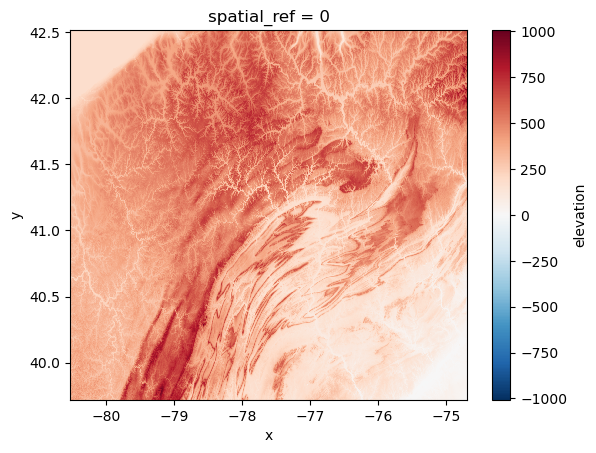

In [11]:
#%matplotlib widget
elevation_array.plot()

### Calculate the elevation mean and std at different kernal sizes

In [12]:
# define kernals as if it was a meter resolution
kernal_resolutions = [1000, 2500, 10000, 50000]

# convert to size tuples
kernal_tuples = []
for res in kernal_resolutions:
    kernal_tuples.append((res // OUTPUT_RESOLUTION, res // OUTPUT_RESOLUTION))

In [13]:
# define a dictionary to store all output dataarrays
combine_z_arrays_dict = {}

In [14]:
%%time
# calculate mean and std at each kernal size
for i, kernal in enumerate(kernal_tuples):
    print(f'Calcualting {kernal_resolutions[i]}x{kernal_resolutions[i]} meter kernal mean/std elevations...')
    for metric in ['mean', 'std']:
        label = f'{metric}_{kernal_resolutions[i]}m'
        array = scipy.ndimage.generic_filter(
            elevation_array.values,
            getattr(np, metric),
            size=kernal,
            )
        out_array = xr.DataArray(
            data=array,
            coords=elevation_array.coords,
            dims=elevation_array.dims,
            name=label,
            )
        del array
        combine_z_arrays_dict[label] = out_array.copy()
        gc.collect()
    print('Done\n')

Calcualting 1000x1000 meter kernal mean/std elevations...
Done

Calcualting 2500x2500 meter kernal mean/std elevations...
Done

Calcualting 10000x10000 meter kernal mean/std elevations...
Done

Calcualting 50000x50000 meter kernal mean/std elevations...
Done

CPU times: total: 21min 2s
Wall time: 22min 52s


In [29]:
# add the original elevation raster to the dictionary
combine_z_arrays_dict[f'elevation_{OUTPUT_RESOLUTION}m'] = elevation_array

### Create relative elevation and topographic roughness features as `xr.DataArray`s

In [145]:
z = combine_z_arrays_dict[f'elevation_{OUTPUT_RESOLUTION}m']
for res in kernal_resolutions:
    print(f'Calcualting elevation features using {res} meter kernal data...')
    # pull in mean and std at each kernal resolution
    mean = combine_z_arrays_dict[f'mean_{res}m']
    mean = mean.where(mean.values > 0)
    std = combine_z_arrays_dict[f'std_{res}m']
    std = std.where(std.values > 0)
    
    # calculate z scores for each cell (relative elevation proxy)
    print('Calculating relative Z')
    combine_z_arrays_dict[f'z_relative_{res}m'] = ((z - mean) / std).compute()
    
    # calculate std/mean for each cell (topographic roughness proxy)
    print('Calculating roughness')
    combine_z_arrays_dict[f'z_roughness_{res}m'] = (std / mean).compute()
    print('Done\n')

Calcualting elevation features using 1000 meter kernal data...
Calculating relative Z
Calculating roughness
Done

Calcualting elevation features using 2500 meter kernal data...
Calculating relative Z
Calculating roughness
Done

Calcualting elevation features using 10000 meter kernal data...
Calculating relative Z
Calculating roughness
Done

Calcualting elevation features using 50000 meter kernal data...
Calculating relative Z
Calculating roughness
Done



In [33]:
combine_z_arrays_dict.keys()

dict_keys(['mean_1000m', 'std_1000m', 'mean_2500m', 'std_2500m', 'mean_10000m', 'std_10000m', 'mean_50000m', 'std_50000m', 'elevation_200m', 'z_relative_1000m', 'z_roughness_1000m', 'z_relative_2500m', 'z_roughness_2500m', 'z_relative_10000m', 'z_roughness_10000m', 'z_relative_50000m', 'z_roughness_50000m'])

In [146]:
# test output fir 1000m kernal
combine_z_arrays_dict['z_relative_10000m'].plot()

### Combine all elevation rasters into a single `xr.DataArray`

In [147]:
# define a function to combine elevation constructed datarrays by a new dimension
def combine_split_bands(
    split_dict: Dict[Union[int, str, np.datetime64], xr.DataArray],
    ) -> xr.DataArray:

    index_name = 'band'
    if isinstance(list(split_dict.keys())[0][-1], np.datetime64): index_name = 'time'

    # re-create the 4th dimension index and concat
    index = pd.Index(
        [i for i in list(split_dict.keys())],
        name=index_name,
        )
    return xr.concat(
        objs=split_dict.values(),
        dim=index,
        )
# save as elevation_features_array
elevation_features_array = combine_split_bands(combine_z_arrays_dict)

In [148]:
elevation_features_array.attrs = elevation_array.attrs
elevation_features_array.name = 'elevation_features'
elevation_features_array

<xarray.DataArray 'elevation_features' (band: 17, y: 1551, x: 2499)>
dask.array<concatenate, shape=(17, 1551, 2499), dtype=float32, chunksize=(1, 1551, 2499), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -80.52 -80.52 -80.52 -80.51 ... -74.7 -74.69 -74.69
  * y            (y) float64 42.51 42.51 42.51 42.51 ... 39.73 39.72 39.72 39.72
    spatial_ref  int32 0
  * band         (band) object 'mean_1000m' 'std_1000m' ... 'z_roughness_50000m'
Attributes:
    SourceBandIndex:  0
    nodatavals:       (nan,)
    _FillValue:       nan

### Query the elevation features at all weather station lat/lon

In [149]:
# create a simple function to sample xarray layers
def sample_raster(
    raster: xr.DataArray,
    lat: float,
    long: float,
    ) -> Union[float, int]:
    """
    :param raster: (xr.DataArray) a raster as a DataArray in memory.
    :param coords: (tuple) coordinate as (lat:float, lon:float) of the cell to be sampled.
    :returns: (float or int) the cell value at param:coords.
    """
    return raster.sel({'x': long,
            'y': lat},
            method='nearest').values.item(0)

In [150]:
unique_stations_df.head()

,latitude,longitude,mean_1000m,std_1000m,mean_2500m,std_2500m,mean_10000m,std_10000m,mean_50000m,std_50000m,elevation_200m,z_relative_1000m,z_roughness_1000m,z_relative_2500m,z_roughness_2500m,z_relative_10000m,z_roughness_10000m,z_relative_50000m,z_roughness_50000m
station_id,,,,,,,,,,,,,,,,,,,
GHCND:US1PAAD0002,39.919185,-76.989416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GHCND:US1PAAD0003,40.001389,-77.108889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GHCND:US1PAAD0006,39.889600,-77.375600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GHCND:US1PAAD0008,39.801061,-77.360635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GHCND:US1PAAD0011,39.919780,-77.301310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
lat=unique_stations_df.iloc[0]['latitude'],
long=unique_stations_df.iloc[0]['longitude']

In [152]:
elevation_features_array.sel(band='elevation_200m').dims

('y', 'x')

In [153]:
elevation_features_array.sel(band='elevation_200m') #[lat, long]

<xarray.DataArray 'elevation_features' (y: 1551, x: 2499)>
dask.array<getitem, shape=(1551, 2499), dtype=float32, chunksize=(1551, 2499), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -80.52 -80.52 -80.52 -80.51 ... -74.7 -74.69 -74.69
  * y            (y) float64 42.51 42.51 42.51 42.51 ... 39.73 39.72 39.72 39.72
    spatial_ref  int32 0
    band         <U14 'elevation_200m'
Attributes:
    SourceBandIndex:  0
    nodatavals:       (nan,)
    _FillValue:       nan

In [108]:
lat

(39.919185,)

In [123]:
long
if isinstance(lat, tuple): lat = lat[0]
if isinstance(long, tuple): long = long[0]

In [126]:
elevation_features_array.sel(band='elevation_200m').sel({'x': long,
            'y': lat},
            method='nearest',
            ).values.item(0)

78.36697387695312

In [ ]:
for i, row in unique_stations_df.iterrows():
    print((row[]))

In [154]:
%time
z_metric_data = {}
for z_metric in list(elevation_features_array.band.values):
    print(z_metric)
    z_metric_data[z_metric] = []
    array = elevation_features_array.sel(band=z_metric)
    for i, row in unique_stations_df.iterrows():
        lat = row['latitude']
        long = row['longitude']
        if isinstance(lat, tuple): lat = lat[0]
        if isinstance(long, tuple): long = long[0]
        
        if isinstance(lat, float) and isinstance(long, float):
            try:
                z_metric_data[z_metric].append(sample_raster(
                        raster=array,
                        lat=lat,
                        long=long,
                    )
                )
            except Exception: z_metric_data[z_metric].append(np.nan)
        else: z_metric_data[z_metric].append(np.nan)

CPU times: total: 0 ns
Wall time: 0 ns
mean_1000m
std_1000m
mean_2500m
std_2500m
mean_10000m
std_10000m
mean_50000m
std_50000m
elevation_200m
z_relative_1000m
z_roughness_1000m
z_relative_2500m
z_roughness_2500m
z_relative_10000m
z_roughness_10000m
z_relative_50000m
z_roughness_50000m


In [158]:
# convert to pandas series
for key in z_metric_data.keys():
    data_list = z_metric_data[key].copy() 
    z_metric_data[key] = pd.Series(data=np.array(data_list),
                                  index=unique_stations_df.index,
                                  name=str(key))

In [164]:
z_metrics_df = pd.DataFrame(z_metric_data).join(unique_stations_df[['latitude', 'longitude']])
z_metrics_df.head()

,mean_1000m,std_1000m,mean_2500m,std_2500m,mean_10000m,std_10000m,mean_50000m,std_50000m,elevation_200m,z_relative_1000m,z_roughness_1000m,z_relative_2500m,z_roughness_2500m,z_relative_10000m,z_roughness_10000m,z_relative_50000m,z_roughness_50000m,latitude,longitude
station_id,,,,,,,,,,,,,,,,,,,
GHCND:US1PAAD0002,142.211609,8.585392,143.223969,10.476520,152.947113,20.934685,188.342026,52.701061,141.386826,-0.096068,0.060371,-0.175358,0.073148,-0.552207,0.136875,-0.890973,0.279816,39.919185,-76.989416
GHCND:US1PAAD0003,187.695862,8.710255,188.547516,15.218628,192.366165,32.269413,198.382721,73.364540,185.465790,-0.256028,0.046406,-0.202497,0.080715,-0.213836,0.167750,-0.176065,0.369813,40.001389,-77.108889
GHCND:US1PAAD0006,321.533447,33.033974,313.591522,36.547913,339.899048,107.777824,256.476685,104.598518,358.751404,1.126657,0.102739,1.235635,0.116546,0.174919,0.317088,0.977784,0.407829,39.889600,-77.375600
GHCND:US1PAAD0008,186.982162,5.928806,190.121063,9.383301,232.018555,72.160690,255.644516,112.320282,185.382462,-0.269818,0.031708,-0.505004,0.049354,-0.646281,0.311013,-0.625551,0.439361,39.801061,-77.360635
GHCND:US1PAAD0011,232.194839,13.505443,227.342392,23.021873,248.232483,64.364517,249.641052,106.429100,240.862686,0.641804,0.058164,0.587280,0.101265,-0.114501,0.259291,-0.082481,0.426329,39.919780,-77.301310


In [167]:
z_metrics_df.shape

(206, 19)

### Save elevation features to a `.parquet`

In [165]:
elevation_parquet_name = f'{STATE}_elevation_features.parquet'

In [166]:
# save to parquet
z_metrics_df.to_parquet(data_dir / elevation_parquet_name, engine='fastparquet')

## Pull in Daymet data and resample to match elevation data

# Exploratory Data Analysis (EDA)